In [2]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),#preprocessing
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
batch_size = 50
test_batch_size = 50#set up dataloaders
dataset = torchvision.datasets.ImageFolder(root="chest_xray/train",transform = transform)
loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)
test = torchvision.datasets.ImageFolder(root="chest_xray/test",transform = transform)
test_loader = DataLoader(dataset, batch_size = test_batch_size, shuffle = True)

In [18]:
vgg = nn.Sequential(*(list(models.vgg16(pretrained = True).children())[:-1])).cuda()
class net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(25088,25088)
        self.ac1 = nn.PReLU(1, 0.01)
        self.fc2 = nn.Linear(25088,2)
        self.smax = nn.Softmax(dim = 1)
    def forward(self, x):
        with torch.no_grad():#model casting vgg to cpu because it won't fit on gpu memory
            x = vgg(x.cuda()).cpu()
        torch.cuda.empty_cache()
        x = x.reshape(-1, 25088)
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.smax(x)
        return x
model = net()


In [16]:
import sys
import torch.optim as optim
opt = optim.Adam(model.parameters(), 0.001)
criterion = nn.NLLLoss()
try:
    for batch,target in loader:
        model.zero_grad()
        output = model(batch)#training loop
        loss = criterion(output, target)
        print("Loss",loss.item())
        print("Accuracy", (torch.sum(torch.argmax(output, dim = 1)==target)/test_batch_size).item())
        loss.backward()
        opt.step()
except KeyboardInterrupt:
    None
    

Loss 0.3757392466068268
Accuracy 0.9599999785423279
Loss 9.124987602233887
Accuracy 0.7799999713897705
Loss 1.2099453210830688
Accuracy 0.8600000143051147
Loss 0.18580885231494904
Accuracy 0.9599999785423279
Loss 0.016852449625730515
Accuracy 1.0
Loss 0.15979301929473877
Accuracy 0.9800000190734863
Loss 0.741456151008606
Accuracy 0.9599999785423279
Loss 1.609480857849121
Accuracy 0.8199999928474426
Loss 0.8977236151695251
Accuracy 0.8600000143051147
Loss 0.5584955811500549
Accuracy 0.9200000166893005
Loss 1.4730099439620972
Accuracy 0.8999999761581421
Loss 0.3122533857822418
Accuracy 0.9599999785423279
Loss 0.35418641567230225
Accuracy 0.9399999976158142
Loss 0.3487526774406433
Accuracy 0.9599999785423279
Loss 0.18803836405277252
Accuracy 0.9800000190734863
Loss 0.16357702016830444
Accuracy 0.9599999785423279
Loss 0.45722511410713196
Accuracy 0.9200000166893005
Loss 2.1519861221313477
Accuracy 0.800000011920929
Loss 1.0938124656677246
Accuracy 0.8600000143051147
Loss 0.6803464293479919

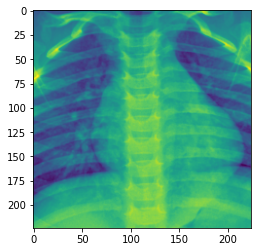

Accuracy 0.9200000166893005


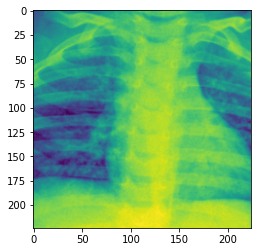

Accuracy 0.9800000190734863


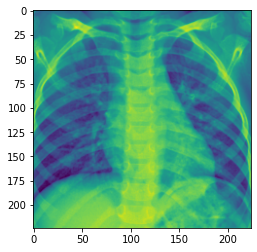

Accuracy 0.9599999785423279


In [17]:
import matplotlib.pyplot as plt
try:
    for batch,target in loader:
        with torch.no_grad():
            output = model(batch)#testing loop
        plt.imshow(batch.numpy()[0][0])
        plt.show()
        print("Accuracy", (torch.sum(torch.argmax(output, dim = 1)==target)/test_batch_size).item())
except KeyboardInterrupt:
    None    